In [20]:
import pandas as pd
import statistics
import random
import numpy as np
from tensorflow import keras
from scipy.stats import multivariate_normal
import shap
import joblib
from xgboost import XGBClassifier, XGBRegressor
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import pearsonr, spearmanr, chi2_contingency, pointbiserialr, f_oneway
from sklearn.preprocessing import StandardScaler,Binarizer, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, f1_score, precision_score, recall_score, auc
pd.options.mode.chained_assignment = None
TF_ENABLE_ONEDNN_OPTS=0

In [21]:
df = pd.read_csv("creditcard.csv")
df_train = pd.read_csv("creditcard_2023.csv")

In [22]:
new_data_test = df.drop(columns = ['Time', 'Class'], axis = 1)
y_new = df['Class']
x = df_train.drop(columns = ['id', 'Class'], axis = 1)
y = df_train['Class']

In [24]:
# split the dataset in to training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [25]:
# Define the FFNN model with an Input layer
model_ffnn = Sequential([
    Dense(64, activation='relu', input_dim=x_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile and train the FFNN model
model_ffnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ffnn.fit(x_train, y_train, epochs=10, batch_size=32)

# Train the XGBoost model
model_xgb = XGBClassifier()
model_xgb.fit(x_train, y_train)

# Make predictions from both models on the training data
predictions_ffnn = model_ffnn.predict(x_train)
predictions_xgb = model_xgb.predict_proba(x_train)[:, 1].reshape(-1, 1)

# Combine predictions into a single 2D matrix
combined_predictions = np.concatenate([predictions_ffnn, predictions_xgb], axis=1)

# Train the meta-model on the combined predictions
meta_model = XGBClassifier()
meta_model.fit(combined_predictions, y_train)


# Make predictions on new data
new_predictions_ffnn = model_ffnn.predict(x_test)
new_predictions_xgb = model_xgb.predict_proba(x_test)[:, 1].reshape(-1, 1)

# Combine predictions for new data
new_combined_predictions = np.concatenate([new_predictions_ffnn, new_predictions_xgb], axis=1)

# Make final predictions using the loaded meta-model
final_predictions = meta_model.predict(new_combined_predictions)

joblib.dump(model_ffnn, 'ffnn_model.h5')
joblib.dump(model_xgb, 'xgb_model.pkl')
joblib.dump(meta_model, 'meta_model.pkl')

print(final_predictions)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14216/14216 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.8634 - loss: 4.3942
Epoch 2/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 33s 2ms/step - accuracy: 0.9455 - loss: 0.1491
Epoch 3/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.9505 - loss: 0.1374
Epoch 4/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.9547 - loss: 0.1256
Epoch 5/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.9562 - loss: 0.1198
Epoch 6/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - accuracy: 0.9579 - loss: 0.1160
Epoch 7/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 39s 2ms/step - accuracy: 0.9569 - loss: 0.1159
Epoch 8/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 43s 2ms/step - accuracy: 0.9573 - loss: 0.1157
Epoch 9/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9572 - loss: 0.1148
Epoch 10/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.9582 - loss: 0.1131
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
[1 1 0 ... 

In [26]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, final_predictions))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56750
           1       1.00      1.00      1.00     56976

    accuracy                           1.00    113726
   macro avg       1.00      1.00      1.00    113726
weighted avg       1.00      1.00      1.00    113726



Confusion Matrix:
[[56555   195]
 [   53 56923]]


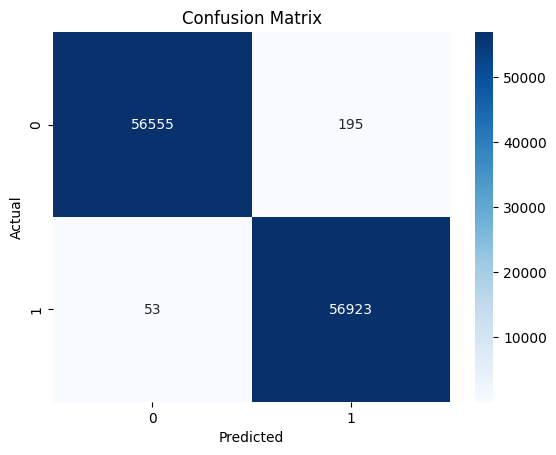

In [27]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, final_predictions)
LABELS = ['0', '1']
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# You can visualize the confusion matrix using seaborn for clarity
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Make predictions on new data
new_predictions_ffnn = model_ffnn.predict(x)
new_predictions_xgb = model_xgb.predict_proba(x)[:, 1].reshape(-1, 1)

# Combine predictions for new data
new_combined_predictions = np.concatenate([new_predictions_ffnn, new_predictions_xgb], axis=1)

# Make final predictions using the loaded meta-model
final_predictions_new = meta_model.predict(new_combined_predictions)

print(final_predictions_new)

17770/17770 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step
[0 0 0 ... 1 1 1]


In [29]:
# Classification report
print("Classification Report:")
print(classification_report(y, final_predictions_new))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       1.00      1.00      1.00    284315

    accuracy                           1.00    568630
   macro avg       1.00      1.00      1.00    568630
weighted avg       1.00      1.00      1.00    568630



Confusion Matrix:
[[283565    750]
 [   157 284158]]


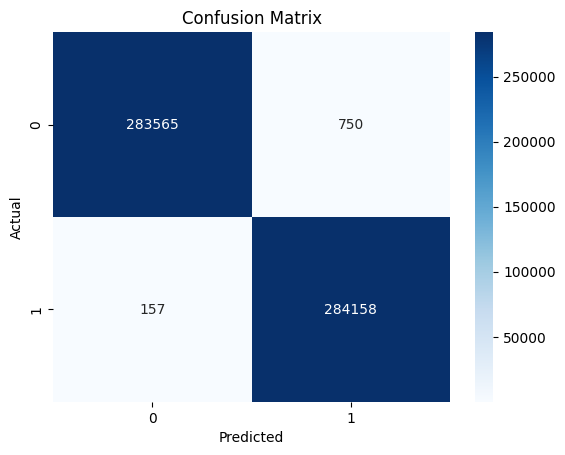

In [30]:
# Confusion matrix
conf_matrix = confusion_matrix(y, final_predictions_new)
LABELS = ['0', '1']
# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# You can visualize the confusion matrix using seaborn for clarity
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

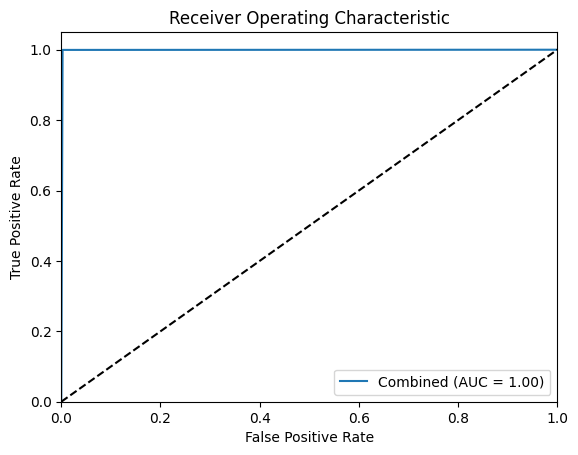

In [31]:
fpr_combined, tpr_combined, _ = roc_curve(y, final_predictions_new)
roc_auc_combined = auc(fpr_combined, tpr_combined)
plt.figure()
plt.plot(fpr_combined, tpr_combined, label='Combined (AUC = %0.2f)' % roc_auc_combined)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()